# Setup

### Model decisions

In [1]:
# Weights and Biases
!pip install -q wandb
# Tensorflow
!pip install -q tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 12.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.1 MB/s eta 0:00:00


In [2]:
previous_loading = False
google_colab = True
moneyness = False
lags = 80
hyperparameter_search = False
training_size = 991232
random_seed = 0
finance_computers = False
fc_path = 'M:/Master/'

In [3]:
if google_colab == True:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


### Imports

In [4]:
from keras.models import Sequential, Model
from keras.layers import Input, LSTM, Concatenate, Dense, BatchNormalization, LeakyReLU
from keras.activations import tanh
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler
import wandb
from wandb.keras import WandbCallback
from datetime import datetime
from dateutil.relativedelta import relativedelta
from tensorflow import square, reduce_mean
from tensorflow.keras.losses import MSE
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.math import multiply
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError
from math import log
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn.metrics import mean_squared_error

In [5]:
# If running in colab, insert your wandb key here

#import config
#Erlend
wandb.login(key='3cae81eb56be3190be5bb48c571e69933071df69')
# Hjalmar
#wandb.login(key="b47bcf387a0571c5520c58a13be35cda8ada0a99")


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Load, split and normalize data

### Load data

In [6]:
if google_colab:
    import tensorflow as tf
    # Print info
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

    if ram_gb < 20:
        print('Not using a high-RAM runtime')
    else:
        print('You are using a high-RAM runtime!')

    # Code to read csv file into Colaboratory:
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials
    # Authenticate and create the PyDrive client.
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    id = "1Doyuyo_VDOmJf0CLo5kl9XzMTfhGtxiR"
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile('2010-2023_NSS_filtered_vF.csv')  
    df_read = pd.read_csv('2010-2023_NSS_filtered_vF.csv')
elif finance_computers:
    file = fc_path + "/data/processed_data/2010-2023_NSS_filtered_vF.csv"
    df_read = pd.read_csv(file)
else:
    file = "../data/processed_data/2010-2023_NSS_filtered_vF.csv"
    df_read = pd.read_csv(file)

display(df_read)

/bin/bash: nvidia-smi: command not found
Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


,Unnamed: 0,Quote_date,Price,Underlying_last,Strike,TTM,R
0,0,2010-01-04,207.490,1132.99,925.0,0.008219,0.00050
1,1,2010-01-04,182.500,1132.99,950.0,0.008219,0.00050
2,2,2010-01-04,157.500,1132.99,975.0,0.008219,0.00050
3,3,2010-01-04,132.600,1132.99,1000.0,0.008219,0.00050
4,4,2010-01-04,107.705,1132.99,1025.0,0.008219,0.00050
...,...,...,...,...,...,...,...
12057638,13739049,2023-03-31,217.750,4109.88,4700.0,1.726027,0.04198
12057639,13739050,2023-03-31,180.000,4109.88,4800.0,1.726027,0.04198
12057640,13739051,2023-03-31,146.550,4109.88,4900.0,1.726027,0.04198
12057641,13739052,2023-03-31,118.200,4109.88,5000.0,1.726027,0.04198


### Create lags

In [7]:
df = df_read
del df_read

if hyperparameter_search:
    df = df[df['Quote_date'] <= '2015-02-01']

# Group the data by Quote Date and calculate the mean for Underlying Price
df_agg = df.groupby('Quote_date').mean().reset_index()

# Values to returns
df_agg["Underlying_return"] = df_agg["Underlying_last"].pct_change()

# Add the Underlying Price Lag column
for i in range(1, lags + 1):
    df_agg['Underlying_' + str(i)] = df_agg['Underlying_return'].shift(i)

df = pd.merge(df, df_agg[['Quote_date', 'Underlying_return'] + ['Underlying_' + str(i) for i in range(1, lags + 1)]], on='Quote_date', how='left')

# Filter df between 2014-01-01 and 2022-12-31
df = df[(df["Quote_date"] >= "2011-09-01") & (df["Quote_date"] <= "2022-12-31")]

print(df)

          Unnamed: 0  Quote_date    Price  Underlying_last  Strike       TTM  \
292779        381812  2011-09-01  304.355          1203.96   900.0  0.002740   
292780        381813  2011-09-01  279.345          1203.96   925.0  0.002740   
292781        381814  2011-09-01  254.355          1203.96   950.0  0.002740   
292782        381815  2011-09-01  229.350          1203.96   975.0  0.002740   
292783        381816  2011-09-01  204.350          1203.96  1000.0  0.002740   
...              ...         ...      ...              ...     ...       ...   
11654831    13280615  2022-12-30  362.600          3839.81  4300.0  1.975342   
11654832    13280616  2022-12-30  319.150          3839.81  4400.0  1.975342   
11654833    13280617  2022-12-30  279.000          3839.81  4500.0  1.975342   
11654834    13280618  2022-12-30  241.950          3839.81  4600.0  1.975342   
11654835    13280619  2022-12-30  208.800          3839.81  4700.0  1.975342   

                 R  Underlying_return  

### Format input data

In [20]:
# Format settings
max_timesteps = lags
bs_vars = ['Moneyness', 'TTM', 'R'] if moneyness else ['Underlying_last', 'Strike', 'TTM', 'R']
underlying_lags = [f'Underlying_{i}' for i in range (max_timesteps - 1, 0, -1)] + ['Underlying_return']

def create_rw_dataset(window_number = 0, df = None):
    '''Creates dataset for a single rolling window period offsett by the window number'''

    # Create train, validation and test set split points
    test_months = 3
    train_start = datetime(2011,9,1) + relativedelta(months=window_number * test_months)
    val_start = train_start + relativedelta(months=3*12)
    test_start = val_start + relativedelta(months = 1 + test_months) if hyperparameter_search else val_start + relativedelta(months = 1)
    test_end = test_start + relativedelta(months=test_months)
    train_start = str(train_start.date())
    val_start = str(val_start.date())
    test_start = str(test_start.date())
    test_end = str(test_end.date())

        
    # Split train and validation data
    df_train = df[(df['Quote_date'] >= train_start) & (df['Quote_date'] < val_start)]
    df_val = df[(df['Quote_date'] >= val_start) & (df['Quote_date'] < test_start)]
    df_test = df[(df['Quote_date'] >= test_start) & (df['Quote_date'] < test_end)]

    del df

    # Extract target values
    train_y = (df_train['Price'] / df_train['Strike']).to_numpy() if moneyness else df_train['Price'].to_numpy()
    val_y = (df_val['Price'] / df_val['Strike']).to_numpy() if moneyness else df_val['Price'].to_numpy()
    test_y = (df_test['Price'] / df_test['Strike']).to_numpy() if moneyness else df_test['Price'].to_numpy()

    # If usining moneyness, extract strike
    if moneyness:
        train_strike = df_train['Strike'].to_numpy()
        val_strike = df_val['Strike'].to_numpy()
        test_strike = df_test['Strike'].to_numpy()


    # Print earliest and latest date in every dataframe used
    print("--------------Dataframe dates--------------")
    print(f"Train: {df_train['Quote_date'].min()} - {df_train['Quote_date'].max()}")
    print(f"Val: {df_val['Quote_date'].min()} - {df_val['Quote_date'].max()}")
    print(f"Test: {df_test['Quote_date'].min()} - {df_test['Quote_date'].max()}")
    print("-------------------------------------------")

    # Convert dataframes to numpy arrays
    train_x = [df_train[underlying_lags].to_numpy(), df_train[bs_vars].to_numpy()]
    val_x = [df_val[underlying_lags].to_numpy(), df_val[bs_vars].to_numpy()]
    test_x = [df_test[underlying_lags].to_numpy(), df_test[bs_vars].to_numpy()]

    del df_train
    del df_val

    # Scale features based on training set
    underlying_scaler = MinMaxScaler()
    train_x[0] = underlying_scaler.fit_transform(train_x[0].flatten().reshape(-1, 1)).reshape(train_x[0].shape)
    val_x[0] = underlying_scaler.transform(val_x[0].flatten().reshape(-1,1)).reshape(val_x[0].shape)
    test_x[0] = underlying_scaler.transform(test_x[0].flatten().reshape(-1,1)).reshape(test_x[0].shape)

    bs_scaler = MinMaxScaler()
    train_x[1] = bs_scaler.fit_transform(train_x[1])
    val_x[1] = bs_scaler.transform(val_x[1])
    test_x[1] = bs_scaler.transform(test_x[1])


    # Shuffle training set
    np.random.seed(random_seed)
    shuffle = np.random.permutation(len(train_x[0]))
    train_x = [train_x[0][shuffle], train_x[1][shuffle]]
    train_y = train_y[shuffle]

    # Extract training set
    train_x = [train_x[0][:training_size], train_x[1][:training_size]]
    train_y = train_y[:training_size]

    if moneyness:
        train_strike = train_strike[shuffle][:training_size]

    # Reshape data to fit LSTM
    train_x = [train_x[0].reshape(len(train_x[0]), max_timesteps, 1), train_x[1]]
    val_x = [val_x[0].reshape(len(val_x[0]), max_timesteps, 1), val_x[1]]
    test_x = [test_x[0].reshape(len(test_x[0]), max_timesteps, 1), test_x[1]]

    print(f'Train shape: {train_x[0].shape}, {train_x[1].shape}')
    print(f'Val shape: {val_x[0].shape}, {val_x[1].shape}')
    print(f'Test shape: {test_x[0].shape}, {test_x[1].shape}')

    if moneyness:
        return train_x, train_y, val_x, val_y, test_x, test_y, train_start, val_start, test_start, df_test, train_strike, val_strike, test_strike,
    return train_x, train_y, val_x, val_y, test_x, test_y, train_start, val_start, test_start, df_test

# Create the dataset for the first rolling window period
if moneyness:
    train_x, train_y, val_x, val_y, test_x, test_y, train_start, val_start, test_start, df_test, train_strike, val_strike, test_strike = create_rw_dataset(df=df)
else:
    train_x, train_y, val_x, val_y, test_x, test_y, train_start, val_start, test_start, df_test = create_rw_dataset(df=df)
    if hyperparameter_search:
        del df

--------------Dataframe dates--------------
Train: 2011-09-01 - 2014-08-29
Val: 2014-09-02 - 2014-09-30
Test: 2014-10-01 - 2014-12-31
-------------------------------------------
Train shape: (991232, 80, 1), (991232, 4)
Val shape: (54323, 80, 1), (54323, 4)
Test shape: (177109, 80, 1), (177109, 4)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

def compute_saliency_map(model, input_data, percentage=0.02):
    n_samples = len(input_data[0])
    sample_size = int(n_samples * percentage)
    
    # Randomly select a subset of samples
    idx = np.random.choice(n_samples, sample_size, replace=False)
    input_data_underlying_sample = tf.convert_to_tensor(input_data[0][idx], dtype=tf.float32)
    input_data_bs_sample = tf.convert_to_tensor(input_data[1][idx], dtype=tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(input_data_underlying_sample)
        tape.watch(input_data_bs_sample)
        output = model([input_data_underlying_sample, input_data_bs_sample])

    grads = tape.gradient(output, [input_data_underlying_sample, input_data_bs_sample])
    grads_underlying = grads[0]
    grads_bs = grads[1]

    saliency_map_underlying = np.mean(np.abs(grads_underlying.numpy()), axis=0)
    saliency_map_bs = np.mean(np.abs(grads_bs.numpy()), axis=0)

    return saliency_map_underlying, saliency_map_bs



input_data = train_x  # or use val_x


In [10]:
model = load_model(f'/content/drive/MyDrive/01. Masters Thesis - Shared/05. Checkpoints/05-01_12-12/2019-03-01/.h5')


In [11]:
saliency_map_underlying, saliency_map_bs = compute_saliency_map(model, input_data)

In [32]:
print(f'saliency_map_underlying shape: {saliency_map_underlying.shape}')
print(f'saliency_map_bs shape: {saliency_map_bs.shape}')
saliency_map_bs = np.reshape(saliency_map_bs, (-1, 1))
print(f'saliency_map_bs shape: {saliency_map_bs.shape}')
print(saliency_map_bs)
print(saliency_map_underlying)

# Sum of saliency map for underlying
saliency_map_underlying_sum = np.sum(saliency_map_underlying)
print(f'The sum of the saliency map for the underlying is: {saliency_map_underlying_sum}')
# Sum of saliency map for bs
saliency_map_bs_sum = np.sum(saliency_map_bs)
print(f'The sum of the saliency map for the bs is: {saliency_map_bs_sum}')
print("The proportion of the saliency map for the underlying is: ", saliency_map_underlying_sum / (saliency_map_underlying_sum + saliency_map_bs_sum))


saliency_map_underlying shape: (80, 1)
saliency_map_bs shape: (4, 1)
saliency_map_bs shape: (4, 1)
[[1827.6332  ]
 [3329.1501  ]
 [ 306.29645 ]
 [  50.510494]]
[[ 1.3355143]
 [ 1.3549353]
 [ 2.2618206]
 [ 2.9174664]
 [ 3.3938546]
 [ 3.7990851]
 [ 4.143394 ]
 [ 4.474034 ]
 [ 4.7788677]
 [ 5.08702  ]
 [ 5.4044905]
 [ 5.734667 ]
 [ 6.088676 ]
 [ 6.4453635]
 [ 6.835389 ]
 [ 7.2455225]
 [ 7.658304 ]
 [ 8.09961  ]
 [ 8.549332 ]
 [ 9.012971 ]
 [ 9.489974 ]
 [ 9.979466 ]
 [10.475133 ]
 [10.982166 ]
 [11.494466 ]
 [12.033699 ]
 [12.546245 ]
 [13.079822 ]
 [13.603431 ]
 [14.1376705]
 [14.67691  ]
 [15.184026 ]
 [15.733035 ]
 [16.261337 ]
 [16.801468 ]
 [17.332216 ]
 [17.893692 ]
 [18.46424  ]
 [19.054548 ]
 [19.656088 ]
 [20.242842 ]
 [20.803185 ]
 [21.327862 ]
 [21.800032 ]
 [22.206854 ]
 [22.51944  ]
 [22.797174 ]
 [22.941675 ]
 [22.980242 ]
 [22.955778 ]
 [22.83117  ]
 [22.638407 ]
 [22.307472 ]
 [21.934376 ]
 [21.446007 ]
 [20.903948 ]
 [20.289087 ]
 [19.650015 ]
 [18.939503 ]
 [18.246906 ]


In [24]:
import datetime

start_date = datetime.date(2011, 9, 1)
end_date = datetime.date(2014, 8, 29)
date_list = []

for year in range(start_date.year, end_date.year + 1):
    for month in [1, 4, 7, 10]:
        current_date = datetime.date(year, month, 1)
        if start_date <= current_date <= end_date:
            date_list.append(current_date)
            

[datetime.date(2011, 10, 1), datetime.date(2012, 1, 1), datetime.date(2012, 4, 1), datetime.date(2012, 7, 1), datetime.date(2012, 10, 1), datetime.date(2013, 1, 1), datetime.date(2013, 4, 1), datetime.date(2013, 7, 1), datetime.date(2013, 10, 1), datetime.date(2014, 1, 1), datetime.date(2014, 4, 1), datetime.date(2014, 7, 1)]


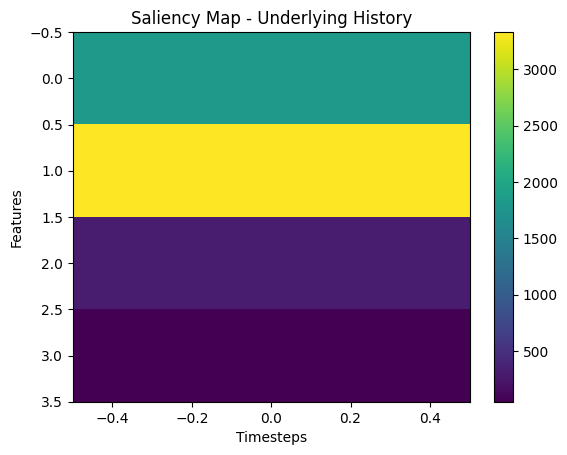

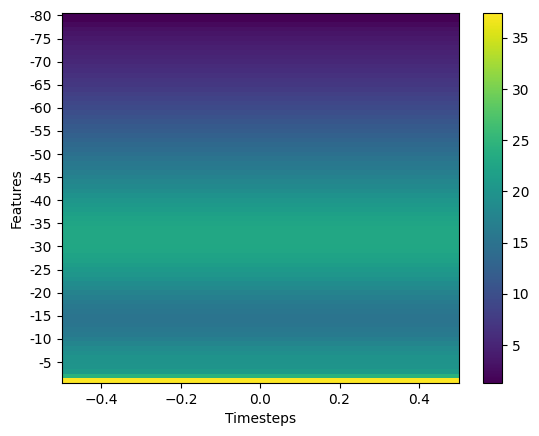

In [29]:
# Saliency map for underlying history
bs_variables = ['Underlying', 'Strike Price', 'Time to Maturity', 'Rent']
quote_dates = date_list
print(quote_dates)
plt.imshow(saliency_map_bs, cmap='viridis', aspect='auto')
# Create axis ticks
ax = plt.gca()
plt.colorbar()
plt.xlabel('Timesteps')
plt.ylabel('Features')
plt.title('Saliency Map - Underlying History')
plt.show()

# Saliency map for underlying history
lag_steps = [x for x in range(-max_timesteps, 0)]
plt.imshow(saliency_map_underlying, cmap='viridis', aspect='auto')
plt.colorbar()
plt.yticks(range(len(lag_steps)), lag_steps)
ax = plt.gca()
ax.yaxis.set_major_locator(ticker.MultipleLocator(base=5))
plt.xlabel('Timesteps')
plt.ylabel('Features')
plt.show()